In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import math
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from  tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1. Import packages and check versions 

In [2]:
print('Tensorflow version:',tf.__version__)

Tensorflow version: 2.6.2


## 2. Define Program Constants

In [3]:
DATA_DIR = './data/'
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_SHAPE = (IMAGE_HEIGHT,IMAGE_WIDTH)
INPUT_LAYER_SHAPE = (IMAGE_HEIGHT,IMAGE_WIDTH, 3) #RGB color for last value
IMAGE_PROCESSING_BATCH_SIZE = 32
VALIDATION_SPLIT=0.2
SEED=123
BATCH_SIZE=128
EPOCHS=5

In [ ]:
# Constrain the randomness
random.seed(SEED)
tf.random.set_seed(SEED)

## 3. Make image generation and formatting objects

In [4]:
img_data_gen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=VALIDATION_SPLIT)

train_generator = img_data_gen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SHAPE,
    batch_size=IMAGE_PROCESSING_BATCH_SIZE,
    class_mode='categorical',
    seed=SEED,
    subset='training') # set as training data

validation_generator = img_data_gen.flow_from_directory(
    DATA_DIR, # same directory as training data
    target_size=IMAGE_SHAPE,
    batch_size=IMAGE_PROCESSING_BATCH_SIZE,
    class_mode='categorical',
    seed=SEED,
    subset='validation') # set as validation data

Found 60 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


### Sample Image

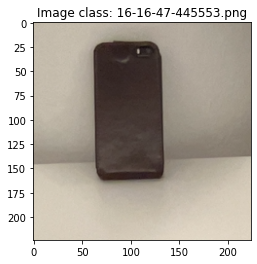

In [5]:
images_paths = [os.path.join(path, name) for path, subdirs, files in os.walk(DATA_DIR) for name in files]

image_path = images_paths[random.randint(0, len(images_paths) - 1)]

image = mpimg.imread(image_path)     
image_type=image_path.split('/')[3]
plt.title('Image class: %s' % image_type)
plt.imshow(image)
plt.show()

## 4. Define hyperparameter grid search

In [35]:
from tensorboard.plugins.hparams import api as hp

HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.25]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))
HP_LEARNING_RATE = hp.HParam('lr', hp.Discrete([1e-5]))
HP_STRIDES = hp.HParam('strides', hp.Discrete([3]))
HP_KERNEL_SIZE = hp.HParam('kernel_size', hp.Discrete([ 4, 5])) 
HP_POOL_SIZE = hp.HParam('pool_size', hp.Discrete([2]))

## 5. Define Network Architecture

In [36]:
from tensorflow.keras import layers

## Output layer interface
OUTPUT_LAYER = layers.Dense(train_generator.num_classes, activation="softmax")

In [37]:

from tensorflow import keras

def build_model_architecture(hyper_params) -> keras.Model: 

    return keras.Sequential([
                    keras.Input(shape=INPUT_LAYER_SHAPE),
                    layers.Conv2D(32, kernel_size=hyper_params[HP_KERNEL_SIZE], activation="relu"),
                    layers.MaxPooling2D(pool_size=hyper_params[HP_POOL_SIZE], strides=hyper_params[HP_STRIDES]),
                    layers.Conv2D(64, kernel_size=hyper_params[HP_KERNEL_SIZE], activation="relu"),
                    layers.MaxPooling2D(pool_size=hyper_params[HP_POOL_SIZE], strides=hyper_params[HP_STRIDES]),
                    layers.Flatten(),
                    layers.Dense(hyper_params[HP_NUM_UNITS], activation=tf.nn.relu),
                    layers.Dropout(0.5),
                    OUTPUT_LAYER,
                ])


## 6. Clean up log folder and start up Tensorboard

In [38]:
try:
    for dir in os.listdir('./logs/'):
        print(dir)
        os.removedirs(f'./logs/{dir}')
except:
    print('Error when trying to remove log directory')

id_20012023181115
Error when trying to remove log directory


In [39]:
%load_ext tensorboard

%tensorboard --logdir logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4644), started 2:27:05 ago. (Use '!kill 4644' to kill it.)

## 7. Run the training session

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime

assert HP_NUM_UNITS.domain is not None, 'HP_NUM_UNITS has no "Domain" attribute'
for num_units in HP_NUM_UNITS.domain.values:

    assert HP_DROPOUT.domain is not None, 'HP_DROPOUT has no "Domain" attribute'
    # for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for dropout_rate in HP_DROPOUT.domain.values:
    
        assert HP_OPTIMIZER.domain is not None, 'HP_OPTIMIZER has no "Domain" attribute'
        for optimizer in HP_OPTIMIZER.domain.values:
        
            assert HP_LEARNING_RATE.domain is not None, 'HP_LEARNING_RATE has no "Domain" attribute'
            for learning_rate in HP_LEARNING_RATE.domain.values:
                
                assert HP_STRIDES.domain is not None, 'HP_STRIDES has no "Domain" attribute'
                for strides in HP_STRIDES.domain.values:
               
                    assert HP_KERNEL_SIZE.domain is not None, 'HP_KERNEL_SIZE has no "Domain" attribute'
                    for kernel_size in HP_KERNEL_SIZE.domain.values:
                    
                        assert HP_POOL_SIZE.domain is not None, 'HP_POOL_SIZE has no "Domain" attribute'
                        for pool_size in HP_POOL_SIZE.domain.values:
                            
                            run_id = f'id_{datetime.now().strftime("%d%m%Y%H%M%S")}'.replace(' ', '_')
                            
                            assert type(optimizer) == str

                            hparams = {
                                HP_NUM_UNITS: num_units,
                                HP_DROPOUT: dropout_rate,
                                HP_OPTIMIZER: optimizer,
                                HP_LEARNING_RATE: learning_rate,
                                HP_STRIDES: strides,
                                HP_KERNEL_SIZE: kernel_size,
                                HP_POOL_SIZE: pool_size
                            }
                            print('--- Starting trial: %s' % run_id)

                            print({h.name: hparams[h] for h in hparams})

                            run_dir = f'logs/{run_id}'
                            
                            op = keras.optimizers.Adam(learning_rate=learning_rate) if optimizer == 'adam' else keras.optimizers.SGD(learning_rate=learning_rate)
                            
                            model = build_model_architecture(hparams)

                            model.compile(
                                loss="categorical_crossentropy",    
                                optimizer=op, metrics=["accuracy"]
                            )

                            # fit the model
                            history = model.fit(
                                train_generator,
                                validation_data=validation_generator,
                                batch_size=BATCH_SIZE,
                                epochs=EPOCHS,
                                verbose=2,
                                callbacks=[
                                    EarlyStopping(
                                        monitor='loss',
                                        mode='min',
                                        patience=5,
                                        min_delta=0.001,
                                        restore_best_weights=True
                                    ),
                                    tf.keras.callbacks.TensorBoard(
                                        run_dir, histogram_freq=1),  # log metrics
                                    hp.KerasCallback(run_dir, hparams),  # log hparams
                                ]
                            )

                            # Evaluate on Validation data
                            # loss, acc = model.evaluate(validation_generator)
                            # print("Val loss:", loss, "Accuracy",acc)
                            
                            model.save(run_dir + '/model')


--- Starting trial: id_20012023184328
{'num_units': 16, 'dropout': 0.25, 'optimizer': 'adam', 'lr': 1e-05, 'strides': 3, 'kernel_size': 4, 'pool_size': 2}
Epoch 1/5
2/2 - 3s - loss: 0.7984 - accuracy: 0.2667 - val_loss: 0.7543 - val_accuracy: 0.2857
Epoch 2/5
2/2 - 2s - loss: 0.7557 - accuracy: 0.3000 - val_loss: 0.7071 - val_accuracy: 0.3571
Epoch 3/5
2/2 - 2s - loss: 0.6930 - accuracy: 0.5833 - val_loss: 0.6741 - val_accuracy: 0.7143
Epoch 4/5
2/2 - 2s - loss: 0.6765 - accuracy: 0.5833 - val_loss: 0.6465 - val_accuracy: 0.7143
Epoch 5/5
2/2 - 2s - loss: 0.6340 - accuracy: 0.6500 - val_loss: 0.6246 - val_accuracy: 0.7143
INFO:tensorflow:Assets written to: logs/id_20012023184328/model/assets
--- Starting trial: id_20012023184340
{'num_units': 16, 'dropout': 0.25, 'optimizer': 'adam', 'lr': 1e-05, 'strides': 3, 'kernel_size': 5, 'pool_size': 2}
Epoch 1/5
2/2 - 3s - loss: 0.7055 - accuracy: 0.4333 - val_loss: 0.7022 - val_accuracy: 0.3571
Epoch 2/5
2/2 - 2s - loss: 0.6951 - accuracy: 0.5